# Topic-Sensitive PageRank

The PageRank algorithm could be modified so that it can put more weight to certain pages depending on some topic. One possible motivation for this is to make search results more relevant to the user. The *Topic-Sensitive PageRank* creates a vector for a set of topics with the goal of giving bias to these topics.  Obviously, the ideal case would be to create one vector per user, but this is simply not possible. Having vectors for only a number of topics, while more limited, can still provide more relevant search results.

Deciding on the topic set is the first step in implementing Topic-Sensitive PageRank.  One such possible set is the top-level categories of the [Open Directory](https://dmoz-odp.org/): Arts, Business, Computers, etc.

We have saved the functions we have defined in the previous sections in a module called $linkana$. We import that module below, together with `numpy`.

In [1]:
import numpy as np
import linkana

## Description

The implementation of Topic-Sensitive PageRank is similar to the general PageRank, except that teleports only happen to a predefined **teleport set** consisting of pages from a specific topic. 

Given
- $S$ -  the indices of the pages belonging to the teleport set
- $|S|$ - the size of the teleport set
- $\textbf{e}_s$ - vector such that
  
    $
        {\large \textbf{e}_{s_{i}}}=\left\{
        \begin{array}{@{}ll@{}}
        1, & \text{if } i \text{ is in } S \\
        0, & \text{otherwise}
        \end{array}\right.
    $

Then, the *topic-sensitive PageRank* for $S$ is the limit of the following iteration:

   $$
        \textbf{v'}= \beta M\textbf{v} + (1-\beta)\textbf{e}_s/|S|
   $$

## Implementation

We implement below the algorithm just described:

In [2]:
def topic_sensitive_page_rank(M, S, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the topic-sensitive PageRank (with taxation) of a given Transition Matrix 

    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    beta :  float
        probability of following an outlink
    S :  list
        indices of pages belonging to the teleport set (indices start at 0)
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the PageRank values 
    """
    
    n = M.shape[0]
    e = np.zeros(n)
    for i in S:
        e[i] = 1
        
    v = np.ones(n)
    delta = 1/tol # initialize to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = beta*M.dot(v) + ((1-beta)/len(S))*e
        delta = np.mean(np.abs(v-prev_v))
        if i >= max_iter:
            break        
    return v

To illustrate, recall Graph 1:

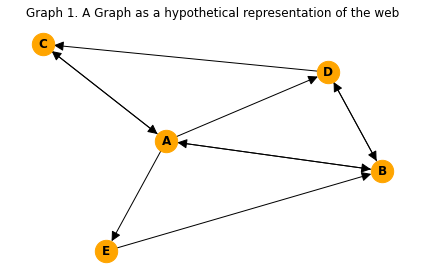

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.DiGraph()
G1.add_nodes_from(["A","B","C","D","E"])
G1.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), ("A","E"), 
    ("B","A"), ("B","D"), 
    ("C","A"),    
    ("D","B"), ("D","C"),
    ("E","B"),
])

plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G1, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

Assuming that pages B and D are our teleport set, we can implement the Topic-Sensitive PageRank in Graph1 as follows:

In [4]:
S = [1,3]
M = linkana.transition_matrix(G1)
topic_sensitive_page_rank(M,S)

array([0.24028021, 0.29252947, 0.15408413, 0.26506858, 0.04805632])

##  Using Topic-Sensitive PageRank in a search engine
Topic-Sensitive PageRank can be used by a search engine following the steps below:
1. Choose a set of topics
2. Decide on a teleport set for each topic
3. Given a query, find the most relevant topic
4. Use the corresponding teleport set in calculating the topic-sensitive PageRank

# Link Spam

When it became obvious that *term spam* was no longer working well with search algorithms such as PageRank, malevolent people found yet another way to fool the PageRank algorithm into wrongly assessing the importance of their pages according to their purposes. In this section, we will look at this new technique called **link spam** and how it can be countered.

Figure 7 below shows how a *spam farm* operates to drive traffic to a target page. 

<img src='images/SpamFarm.PNG' width='450px'></img>
<center><b>Figure 1. Spam Farm architechture</b></center>
<center><small>Image adapted from Leskovec, Rajaraman, and Ullman. Mining of Massive Datasets, 2019.</small></center>

Examples of accessible pages are blogs, newspapers or other sites where people can leave comments like “That's nice! I also wrote about it in my blog at hiddenSpamFarm.com."

**PageRank increase contributed by Link Spam** 

As discussed by Leskovec et al., in their book Mining of massive datasets (http://www.mmds.org/), it can be shown that:

Given
* $n$ - total number of pages in the Web
* $x$ - PageRank contributed by accessible pages
* $m$ - own/supporting pages in the spam farm
* $y$ - PageRank of the target page

    $\large {  y = a x + c \frac{m}{n}  }$

where 
* $a =1/({1-\beta^2}$)
* $c = \beta/(1+\beta)$ 

In the formulas above, $a$ represents the contribution of the accessible pages to the target page's PageRank, while $c$ represents the PageRank contributed by the spam farm, expressed as a ratio of the number of pages in the spam farm to the total number of pages in the enitre web.

Let's compute the values of $a$ and $c$ assuming that  $\beta$=0.8.

In [5]:
beta = 0.8
a = 1/(1-beta**2)
c = beta/(1+beta)
a, c

(2.7777777777777786, 0.4444444444444445)

In the next subsections, we will discuss two possible ways of combating Link Spam: *TrustRank* and *Spam Mass*. 

# TrustRank

*TrustRank* is a variation of the Topic-Sensitive PageRank where the *'topic'* that defines the teleport set is a set of pages that are believed to be trustworthy. 

A feasible way of selecting the trustworthy pages is to pick a domain whose membership is controlled. Examples are `.edu`, `.gov`, `.mil`.

# Spam Mass

The idea of Spam Mass is to deduct PageRank scores from pages which are considered spam. This can be done by calculating both the PageRank score and the TrustRank score. 

Given 
* $r$ - PageRank of a page
* $t$ - TrustRank of the same page

The page's spam mass $p$ is calculated as follows:

$$ p = (r-t)/r $$

Below is an implementation of spam mass which calls the `idealized_page_rank` and `topic_sensitive_page_rank` functions from our `linkana` module.

In [6]:
def spam_mass(M, S, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the spam mass given a set of trustworthy pages

    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    beta :  float
        probability of following an outlink; passed to page_rank_ts
    S :  list
        indices of trustworthy pages (indices start at 0)
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    p : numpy array
        Vector containing the spam mass 
    """
    r = linkana.idealized_page_rank(M, tol=tol, max_iter=max_iter)
    t = linkana.topic_sensitive_page_rank(M, S=S, beta=beta, tol=tol, max_iter=max_iter)
    p = (r-t)/r
    return p

Let's check the spam mass of Graph1 if nodes B and D are in the teleport set.

In [7]:
spam_mass(M, [1, 3])

array([ 0.19906599, -0.17011728,  0.11951934, -0.32534358,  0.35924862])

**REFERENCE**

* Jure Leskovec, Anand Rajaraman, and Jeffrey D Ullman. Mining of massive datasets, chapter 5. Cambridge University Press, 3rd edition, 2019. http://www.mmds.org/. All figures, except Figure 2, were cropped from this book. Figure 2 was adapted from the presentation slides made available by the authors of the same book.